C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000488
Epoch: 0800 cost = 0.000162
Epoch: 1200 cost = 0.000080
Epoch: 1600 cost = 0.000048
Epoch: 2000 cost = 0.000031
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


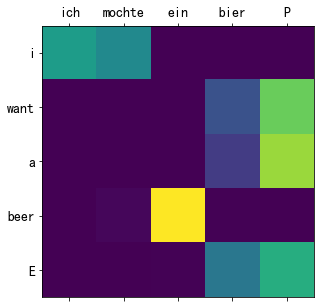

In [2]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

# Parameter
n_hidden = 128

def make_batch(sentences):
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return Variable(torch.Tensor(input_batch)), Variable(torch.Tensor(output_batch)), Variable(torch.LongTensor(target_batch))

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = Variable(torch.empty([n_step, 1, n_class]))

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = Variable(torch.zeros(n_step))  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

input_batch, output_batch, target_batch = make_batch(sentences)

# hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
hidden = Variable(torch.zeros(1, 1, n_hidden))

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(2000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
test_batch = Variable(torch.Tensor(test_batch))
predict, trained_attn = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()